# HbT pipeline

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 12 13:38:43 2023

@author: vincent chouinard
"""
import os
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.filters import threshold_local
import imageio
import sys
import imageio.v2 as imageio
from PyQt5.QtWidgets import QFileDialog, QApplication
import tifffile as tiff
from scipy import stats, ndimage
from scipy.ndimage import gaussian_filter1d, minimum_filter1d
from scipy.signal import medfilt

module_path = r'/Users/vincentchouinard/Documents/GitHub/Widefield-Imaging-analysis'
sys.path.insert(1,module_path)
from WFmovie import WFmovie, create_channel, regress_timeseries, save_figures_as_gif


module_path_chouine = r'/Users/vincentchouinard/Documents/GitHub/WideField'
sys.path.insert(2, module_path_chouine)
from MIFFE import *

ModuleNotFoundError: No module named 'plantcv'

**NOTE:** This notebook requires .tif green and red data for **convert_to_hb** function. If data is not already in .tif, it can be opened and saved as .tif following the **create_movies** and **generate_data_folder** pipeline.

## 1. Opens, corrects and loads data in folderpath

In [14]:
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M35_25juil"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M36_18juil"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M37_18juil"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M37_25juil"
#folderpath = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S4/CVR_M37_8aout"

folderpath = "/Volumes/ChouineUSB/IR_test/without_lens_polarizer"

##### Correction, opening and baseline parameters 

In [15]:
channels_exist = False            # If True: channels already exist and no need to create channels.
channels = ['green', 'red']       # 'green', 'red', 'blue', 'ir'.
data_type = 'corrected'           # Loads corrected .tif if 'corrected', or raw data .tif if 'raw'.
baseline_time = 30                # Baseline seconds at beginning of acquisition.

In [16]:
movies = create_movies(folderpath, channels = channels , channels_exist = channels_exist, stim_path = False, memmap=True)
freq = int(movies[0].freq / movies[0].nchannels)

if data_type == "corrected":
    for i in range(len(channels)):
        generate_data_folder(movies[i], folderpath, channels[i], tif = True, CaImAn = True, numpy = False)
    g_path = folderpath + "/Correction/corrected_green_movie.tif"
    r_path = folderpath + "/Correction/corrected_red_movie.tif"

elif data_type == "raw":
    for i in range(len(channels)):
        generate_data_folder(movies[i], folderpath, channels[i], tif = True, CaImAn = False, numpy = False)
    g_path = folderpath + "/Correction/green_movie.tif"
    r_path = folderpath + "/Correction/red_movie.tif"

data_path: /Volumes/ChouineUSB/IR_test/without_lens_polarizer
stim_path: False
channels: ['ir']
channels_exist: False
binning: False
normalize: False
gaussian_filter: False
gaussian_std: 1
temp_med_filter: False
temp_med_width: 3
substract_background: False
background_path: None


## 2. Creates Hb_data folder in which dHbO/dHbR/dHbT will be saved in .tif

In [5]:
create_hb_data(g_path, r_path, folderpath, baseline = [0 , (freq*baseline_time)])

Directory 'Hb_data' created.


100%|███████████████████████████████████████| 2250/2250 [00:24<00:00, 93.55it/s]

Done! dHbO/dHbR/dHbT .tifs are now saved in Hb_data.


In [316]:
os.chdir(module_path)
convert_to_hb(g_path , r_path , save_path , baseline = [0 , (freq*baseline_time)] , bin_size=2)
os.chdir(module_path_chouine)

print("Done! dHbO/dHbR/dHbT .tifs are now saved in Hb_data.")

100%|███████████████████████████████████████| 2250/2250 [00:25<00:00, 87.53it/s]

Done! dHbO/dHbR/dHbT .tifs are now saved in Hb_data.


## Analysis

In [5]:

#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M34_18juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M35_18juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M36_18juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M37_18juil/Hb_data/dHbT.tif"

#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M34_25juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M35_25juil/Hb_data/dHbT.tif"
dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M37_25juil/Hb_data/dHbT.tif"


In [6]:
im = tiff.imread(dHbT_path)

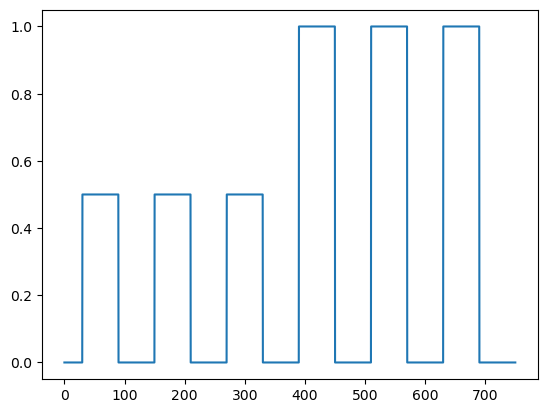

In [7]:
CVR_stim = np.zeros(im.shape[0])
CVR_stim[90:270] = 0.5
CVR_stim[450:630] = 0.5
CVR_stim[810:990] = 0.5
CVR_stim[1170:1350] = 1
CVR_stim[1530:1710] = 1
CVR_stim[1890:2070] = 1
time = np.linspace(0,im.shape[0]/3,im.shape[0])
plt.plot(time, CVR_stim)
plt.show()

In [9]:
def exponential(t, tau=6):
    return np.exp(-(t / tau))

In [10]:
from scipy.signal import convolve

##### (kernel needs to have the same framerate, so 3 frames by second for the time of the acquisition)

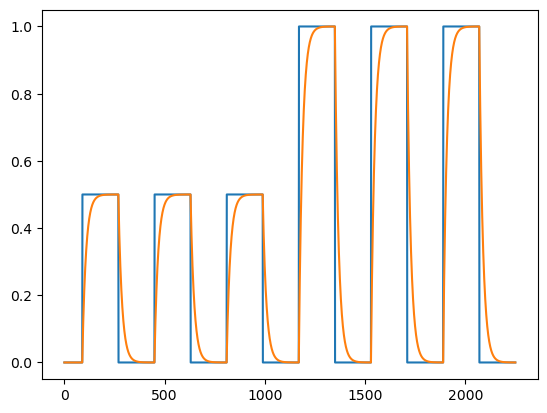

In [11]:
kernel = exponential(time)
regressor = convolve(CVR_stim, kernel)[:len(CVR_stim)]
regressor /= np.max(regressor)

plt.plot(CVR_stim)
plt.plot(regressor)

In [354]:
signal = im[:,130:150, 120:140]
signal = np.mean(signal, axis=(1,2))

In [357]:
def baseline_minfilter(signal, window=300, sigma1=5, sigma2=100, debug=False):
    signal_flatstart = np.copy(signal)
    signal_flatstart[0] = signal[1]
    smooth = gaussian_filter1d(signal_flatstart, sigma1)
    mins = minimum_filter1d(smooth, window)
    baseline = gaussian_filter1d(mins, sigma2)
    if debug:
        debug_out = np.asarray([smooth, mins, baseline])
        return debug_out
    else:
        return baseline

In [358]:
baseline = baseline_minfilter(signal, sigma1 = 7, sigma2=150)
detrended = signal-baseline

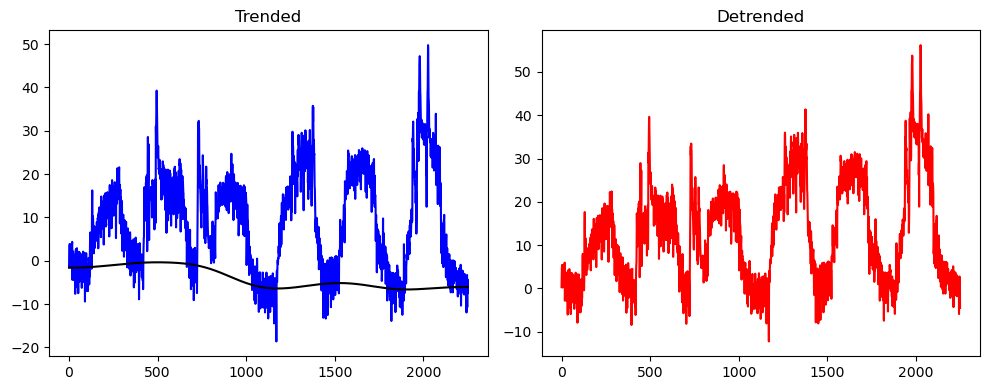

In [359]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot data on each subplot
axs[0].plot(signal, color='blue')
axs[0].plot(baseline, color='black')
axs[0].set_title('Trended')

axs[1].plot(detrended, color='red')
axs[1].set_title('Detrended')

# Display the figure with subplots
plt.tight_layout()
plt.show()

In [360]:
# def fit_signal(signal1, signal2):
#     """Fit one-dimensional signal1 to signal2 using simple inversion of a linear matrix equation.
#     Returns: fit coefficients (a, b) and fit signal a * signal1 + b."""
#     signal1 = np.expand_dims(signal1.flatten(), axis=1)  # (N x 1) vector
#     signal2 = np.expand_dims(signal2.flatten(), axis=1)  # (N x 1) vector
#     vectors = np.concatenate([signal1, np.ones((signal1.shape[0], 1))], axis=1)  # (N x 2) matrix
#     coeffs = (np.linalg.pinv(vectors) @ signal2).flatten()
#     fit = coeffs[0] * signal1 + coeffs[1]
#     return coeffs, fit

In [361]:
# coeffs, fit = fit_signal(regressor, detrended)

In [362]:
norm_detrended = detrended / np.max(detrended)

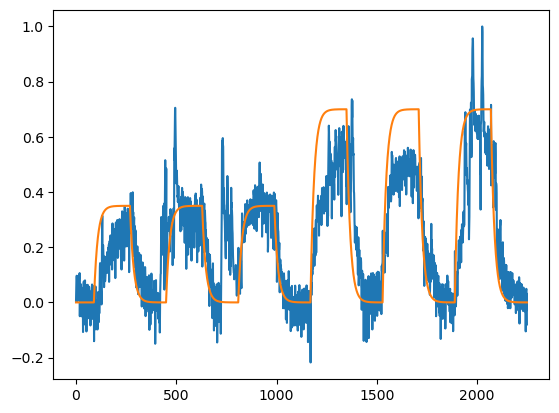

In [363]:
plt.plot(norm_detrended)
plt.plot(regressor*0.7)

In [364]:
med_filt_detrended = medfilt(norm_detrended, kernel_size=5)

# Correlation maps

In [365]:
im.shape

(2250, 280, 299)

In [366]:
corr = np.zeros((im.shape[1], im.shape[2]))
corr.shape

(280, 299)

In [367]:
for x in tqdm(range(im.shape[2])):
    for y in range(im.shape[1]):
        corr[y,x] = np.corrcoef(regressor,im[:,y,x])[0,1]

100%|█████████████████████████████████████████| 299/299 [00:13<00:00, 21.71it/s]


In [89]:
plt.imshow(corr, vmin = 0.4 , vmax = 0.9)
plt.colorbar()

NameError: name 'corr' is not defined

## Hétérogénéité potentiellement dûe au behavior . Mais, pouquoi c'est les veines sont les moins corrélées ? Intéressant

In [11]:
video_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil_video/CVR_M34_18juil_video.mp4"
save_path  = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil_video/CVR_M34_18juil_video_realstart.tif"

# Motion energy

In [12]:
import numpy as np
from numba import njit

@njit
def compute_diff(current, last):
    return np.mean(np.abs((current - last) / 255 ))

In [13]:
import cv2
import tifffile as tiff
import numpy as np
from tqdm import tqdm

def motion_energy(input_file, frame_range = [0, -1]):
    
    video = cv2.VideoCapture(input_file)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_range[1] == -1:
        frame_range[1] = total_frames
        
    frame_counter = frame_range[0]
    last_frame = None
    diff = np.zeros((frame_range[1] - frame_range[0]) - 1)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        
    for i in tqdm(range(frame_range[1] - 1)):
        _, frame = video.read()

        
        current_frame = cv2.cvtColor(frame[:, 420:1500], cv2.COLOR_BGR2GRAY).astype(np.int16)
        
        if i > 0:
            diff[i-1] = np.mean(np.abs((current_frame - last_frame)/255 ))
        
        last_frame = current_frame
        frame_counter += 1
        
    video.release()
        
    return diff

In [14]:
def remove_webcam_artefacts(signal, floor):
    new_signal = np.copy(signal)
    last_index = len(signal) - 1
    for i in tqdm(np.where(signal<floor)[0]):
        if i < last_index :
            new_signal[i] = ((signal[i-1] + signal[i+1] ) / 2)
        else:
            new_signal[i] = new_signal[i-1]
    return new_signal

In [15]:
diff = motion_energy(video_path)

OpenCV: Couldn't read video stream from file "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil_video/CVR_M34_18juil_video.mp4"


ValueError: negative dimensions are not allowed

In [16]:
filt_diff = remove_webcam_artefacts(diff, 0.006)

NameError: name 'diff' is not defined

# CVR maps

In [26]:
five_stim = CVR_stim[:1170]
five_stim[ five_stim > 0] = 1
five_stim.astype(np.int8)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [29]:
ten_stim = CVR_stim[1170:]
ten_stim[ ten_stim > 0] = 1
ten_stim.astype(np.int8)

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [31]:
def mean_response(arr, binary_arr):
    """
    Compute the mean of a 3D axis along the T-axis, considering only the elements where the binary array is equal to 1.

    Args:
        arr (numpy.ndarray): The 3D array of shape (T, M, N).
        binary_arr (numpy.ndarray): The binary array of shape (T,) indicating which elements to consider.

    Returns:
        numpy.ndarray: The mean along the T-axis, considering only the elements where binary array is equal to 1.
    """
    mask = binary_arr[:, np.newaxis, np.newaxis] != 0.0
    masked_arr = np.where(mask, arr, np.nan)
    mean = np.nanmean(masked_arr, axis=0)

    return mean

In [66]:
five_response = mean_response(im[:len(five_stim)], five_stim)
ten_response = mean_response(im[len(five_stim):], ten_stim)

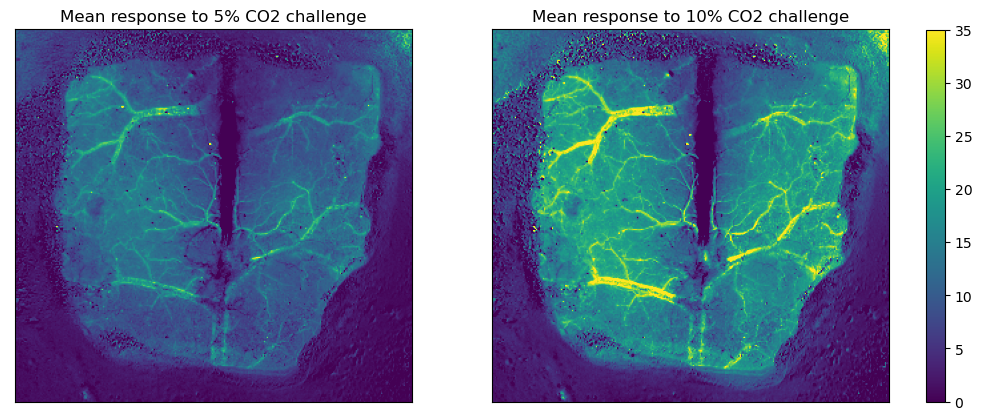

In [95]:
# Define your limits
vmin, vmax = 0, 35

fig, ax = plt.subplots(1,2,figsize=(12,6))
im1 = ax[0].imshow(five_response, vmin=vmin, vmax=vmax)
im2 = ax[1].imshow(ten_response, vmin=vmin, vmax=vmax)

ax[0].set_title("Mean response to 5% CO2 challenge")
ax[1].set_title("Mean response to 10% CO2 challenge")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

# Add a single colorbar for both images
cbar = fig.colorbar(im2, ax=ax, fraction=0.02, pad=0.04)

plt.show()

# Ok donc les valeurs sont pas bonnes, mais ça reste le CVR vu qui reste juste à diviser par le baseline

In [2]:
a = np.load("/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M35_25juil_video/x_array.npy")

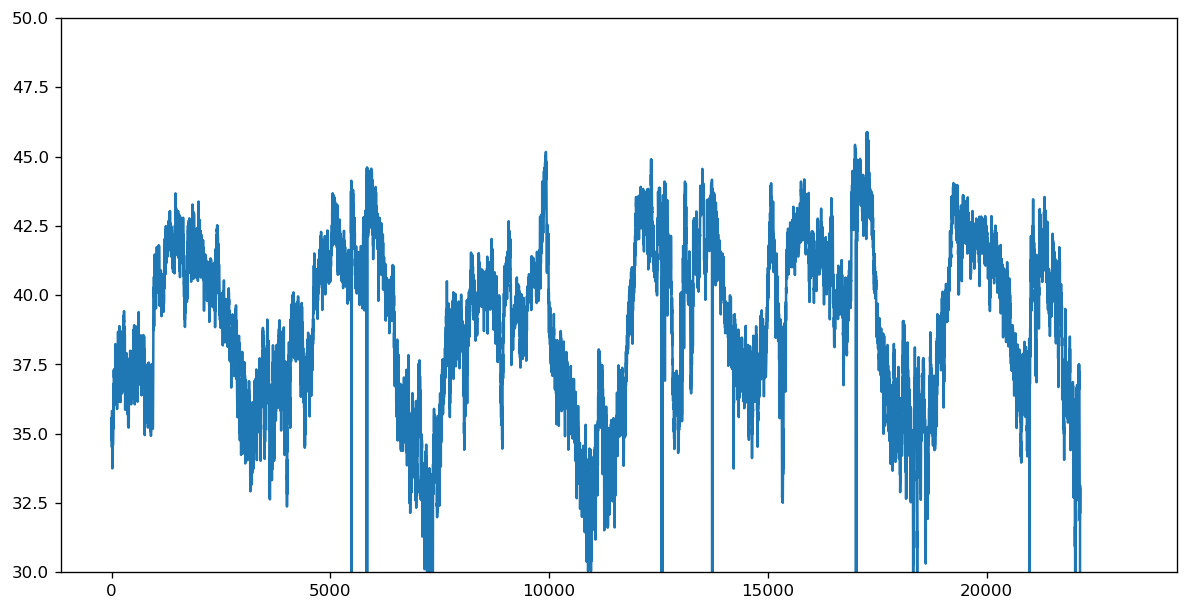

In [8]:
fig, ax = plt.subplots(figsize = (12,6), dpi=120)
plt.plot(a)
plt.ylim(30,50)
plt.show()